<a href="https://colab.research.google.com/github/ArmanveerKaur/ArmanveerKaur/blob/main/Copy_of_RL_Interactive_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Interactive Trading Simulator — `RL_Interactive_Trading`

**What this notebook provides**
- A simple interactive trading simulator where **you** can step through historical price data (daily) and choose **Buy / Hold / Sell** at each step.
- Tracks portfolio (cash, position, portfolio value), shows price chart, and logs trades.
- Includes a small PPO baseline training cell you can run later to compare agent decisions with yours (optional).

**Why this is useful**
- It's a hands-on trading sandbox — you get to make decisions and see immediate consequences.
- Great for exploring reward shaping and for collecting human play data to train imitation learning later.





/tmp/ipython-input-1336523027.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Data loaded: (1741, 9)


,Date,Close,High,Low,Open,Volume,return_1,sma_5,sma_20
0,2018-01-30,39.103012,39.196687,38.571396,38.765775,184192800,-0.005894,39.895515,40.827600
1,2018-01-31,39.210739,39.447275,38.992942,39.079592,129915600,0.002755,39.577483,40.771043
2,2018-02-01,39.292717,39.489437,39.053840,39.149860,188923200,0.002091,39.421514,40.718936
3,2018-02-02,37.587784,39.063193,37.494109,38.875839,346375200,-0.043391,38.905823,40.572215
4,2018-02-05,36.648685,38.379363,36.533930,37.259926,290954000,-0.024984,38.368587,40.355470


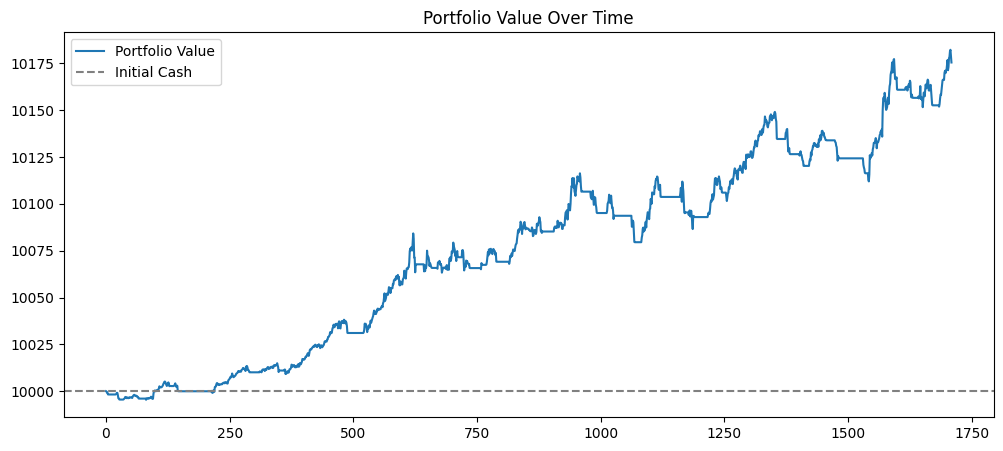

Final value: 10175.49997809982
Trades:
{'step': 1512, 'action': 'sell', 'price': 184.11126708984375}
{'step': 1561, 'action': 'buy', 'price': 171.2926788330078}
{'step': 1565, 'action': 'sell', 'price': 163.6649169921875}
{'step': 1571, 'action': 'buy', 'price': 172.0961151123047}
{'step': 1630, 'action': 'sell', 'price': 217.06570434570312}
{'step': 1646, 'action': 'buy', 'price': 223.4623565673828}
{'step': 1661, 'action': 'sell', 'price': 219.58419799804688}
{'step': 1672, 'action': 'buy', 'price': 225.2025604248047}
{'step': 1701, 'action': 'sell', 'price': 221.66250610351562}
{'step': 1714, 'action': 'buy', 'price': 227.9689483642578}


In [1]:
# Clean, widget-free, GitHub-safe version

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# --------------------------
# Data Download + Indicators
# --------------------------
def download_data(ticker, start='2018-01-01', end='2024-12-31'):
    df = yf.download(ticker, start=start, end=end, progress=False)

    # Flatten multiindex if needed
    if isinstance(df.columns, pd.MultiIndex):
        try:
            lvl0 = list(df.columns.get_level_values(0))
            lvl1 = list(df.columns.get_level_values(1))
            if len(set(lvl1)) == 1:
                df.columns = lvl0
        except Exception:
            df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]

    df = df.dropna()
    return df


def add_basic_indicators(df):
    df = df.copy()
    df['return_1'] = df['Close'].pct_change()
    df['sma_5'] = df['Close'].rolling(5).mean()
    df['sma_20'] = df['Close'].rolling(20).mean()
    df = df.dropna().reset_index()
    return df


# --------------------------
# Manual Trading (non-widget)
# --------------------------
class ManualTrader:
    """
    Non-interactive version:
    - step through automatically
    - logs actions
    """

    def __init__(self, df, initial_cash=10000, transaction_cost_pct=0.001):
        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.transaction_cost_pct = transaction_cost_pct
        self.reset()

    def reset(self):
        self.current_step = 30          # warmup
        self.cash = float(self.initial_cash)
        self.position = 0               # 0 or 1 share
        self.position_price = 0.0
        self.portfolio_history = []
        self.trade_log = []

    def get_price(self, step=None):
        if step is None:
            step = self.current_step
        return float(self.df.loc[step, 'Close'])

    def portfolio_value(self):
        return self.cash + self.position * self.get_price()

    def step_action(self, action: str):
        """
        action: 'buy', 'sell', 'hold'
        """
        price = self.get_price()
        prev_value = self.portfolio_value()

        if action == 'buy' and self.position == 0:
            cost = price * (1 + self.transaction_cost_pct)
            if self.cash >= cost:
                self.cash -= cost
                self.position = 1
                self.position_price = price
                self.trade_log.append({'step': self.current_step, 'action': 'buy', 'price': price})

        elif action == 'sell' and self.position == 1:
            proceeds = price * (1 - self.transaction_cost_pct)
            self.cash += proceeds
            self.position = 0
            self.trade_log.append({'step': self.current_step, 'action': 'sell', 'price': price})

        # hold does nothing

        self.current_step += 1
        value = self.portfolio_value()
        reward = value - prev_value
        self.portfolio_history.append(value)

        return reward

    def run_auto(self, policy="hold"):
        """
        Run automatically:
        policy = 'hold' (default)
        policy = 'sma_cross' (simple strategy)
        """
        while self.current_step < len(self.df) - 1:

            if policy == "hold":
                action = 'hold'

            elif policy == "sma_cross":
                # Simple example strategy
                row = self.df.loc[self.current_step]
                if row['sma_5'] > row['sma_20'] and self.position == 0:
                    action = 'buy'
                elif row['sma_5'] < row['sma_20'] and self.position == 1:
                    action = 'sell'
                else:
                    action = 'hold'

            else:
                action = 'hold'

            self.step_action(action)

        return self.portfolio_value()

    def plot(self):
        plt.figure(figsize=(12, 5))
        plt.plot(self.portfolio_history, label="Portfolio Value")
        plt.axhline(self.initial_cash, linestyle='--', color='gray', label="Initial Cash")
        plt.legend()
        plt.title("Portfolio Value Over Time")
        plt.show()

        print("Final value:", self.portfolio_value())
        print("Trades:")
        for t in self.trade_log[-10:]:
            print(t)


# --------------------------
# Load data & run trader
# --------------------------
ticker = 'AAPL'
df_raw = download_data(ticker)
df = add_basic_indicators(df_raw)

print("Data loaded:", df.shape)
display(df.head())

trader = ManualTrader(df=df)
final_value = trader.run_auto(policy="sma_cross")
trader.plot()
